# Configure the Library

In [2]:
import numpy as np
import pandas as pd
import os
import random
import time

import re
import string
import nltk
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", context="talk")
plt.style.use('dark_background')

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as func
from torch.utils.data import dataloader, dataset

import transformers
from transformers import AdamW, get_linear_schedule_with_warmup

from sklearn.metrics import f1_score, mean_squared_error, roc_auc_score, roc_curve, auc
from sklearn.model_selection import KFold, train_test_split

import warnings
warnings.simplefilter('ignore')

c:\Users\mikew\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# load dataset

In [5]:
train = pd.read_csv('./dataset/train.csv.zip')
test = pd.read_csv('./dataset/test.csv.zip' )
test_label = pd.read_csv('./dataset/test_labels.csv.zip')
#train.head()
#test.head()
#test_label.head()

In [11]:
new_test = pd.merge(test, test_label, on='id', how='inner')
new_test = new_test[(new_test.iloc[:, 3:8] != -1).all(axis=1)]

In [12]:
new_test

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
5,0001ea8717f6de06,Thank you for understanding. I think very high...,0,0,0,0,0,0
7,000247e83dcc1211,:Dear god this site is horrible.,0,0,0,0,0,0
11,0002f87b16116a7f,"""::: Somebody will invariably try to add Relig...",0,0,0,0,0,0
13,0003e1cccfd5a40a,""" \n\n It says it right there that it IS a typ...",0,0,0,0,0,0
14,00059ace3e3e9a53,""" \n\n == Before adding a new product to the l...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
153150,fff8f64043129fa2,":Jerome, I see you never got around to this…! ...",0,0,0,0,0,0
153151,fff9d70fe0722906,==Lucky bastard== \n http://wikimediafoundatio...,0,0,0,0,0,0
153154,fffa8a11c4378854,==shame on you all!!!== \n\n You want to speak...,0,0,0,0,0,0
153155,fffac2a094c8e0e2,MEL GIBSON IS A NAZI BITCH WHO MAKES SHITTY MO...,1,0,1,0,1,0


# Clean the dataset -- helper function for removing non-sense fragment

In [97]:
def clean_text(text):

    text = re.sub('\[.*?\]', '', text)
    #pattern = [zero or more character]

    text = re.sub('https?://\S+|www\.\S+', '', text)
    #pattern = removes (http),://, 'and' www.
    
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    #pattern = any punctionation

    text = re.sub('\n', '', text)
    #pattern = any new line

    text = re.sub('\w*\d\w*', '', text)
    #pattern = any from[a-zA-Z0-9_], any from[0-9], any from [a-zA-Z0-9_]

    return text


train['clean'] = train['comment_text'].apply(str).apply(lambda x: clean_text(x))
test['clean'] = test['comment_text'].apply(str).apply(lambda x: clean_text(x))

# DataLoader

In [98]:
class BertDataSet(dataset.Dataset):
    
    def __init__(self, texts, labels, tokenizer, max_len, if_train=True):
        self.texts = texts
        #self.labels = labels.to_numpy()
        self.if_train = if_train
        if self.if_train:
            self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, item):
        text = str(self.texts.iloc[item])
        
        if self.if_train:
            label = self.labels.iloc[item]

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=False,
            return_attention_mask=True,
            truncation=True
        )

        if self.if_train:
            return {
                #'text': text,
                'input_ids':torch.tensor(inputs['input_ids'], dtype=torch.long),
                'mask': torch.tensor(inputs['attention_mask'], dtype=torch.long),
                'labels': torch.tensor(label, dtype=torch.float)
            }
        else:
            return{
            'input_ids':torch.tensor(inputs['input_ids'], dtype=torch.long),
            'mask': torch.tensor(inputs['attention_mask'], dtype=torch.long)
            }
     

# Model definition

In [99]:
train_batch = 64
valid_batch = 64

epochs = 8

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
print(f"The devices using is : {device}")

#Using K-folder
kf = KFold(n_splits=5, shuffle=True, random_state=42)
#X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
# fold_index = 0

fold_losses = []
fold_valid = []

best_model  = None
best_loss = None
best_index = 0

loss_fn = nn.BCEWithLogitsLoss() # for sigmoid on multi-label tasks
loss_fn.to(device)

tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
model = transformers.BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels = 6).to(device)

The devices using is : cuda


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# train

In [84]:
train_index, valid_index = next(iter(kf.split(train)))

train_kf = train.iloc[train_index]
valid_kf = train.iloc[valid_index]

train_dataset = BertDataSet(train_kf['clean'], train_kf[['toxic', 'severe_toxic','obscene', 'threat', 'insult','identity_hate']], tokenizer, 77)
valid_dataset = BertDataSet(valid_kf['clean'], valid_kf[['toxic', 'severe_toxic','obscene', 'threat', 'insult','identity_hate']], tokenizer, 77)

#train_dataset = BertDataSet(train_kf, tokenizer, eval_mode = False)
#valid_dataset = BertDataSet(valid_kf, tokenizer, eval_mode = True)

train_dataloader = dataloader.DataLoader(train_dataset, batch_size = train_batch, pin_memory = True, num_workers = 0, shuffle = True)
valid_dataloader = dataloader.DataLoader(valid_dataset, batch_size = valid_batch, pin_memory = True, num_workers = 0, shuffle = False)

LR  = 1e-6
optimizer = AdamW(model.parameters(), LR, betas = (0.9, 0.999), weight_decay = 1e-2, correct_bias = False)

training_losses = []
valid_losses = []


for epoch in range(epochs):   
    model.train()
    total_loss = 0 
    valid_loss = 0
    with torch.cuda.amp.autocast():
    
        for batch in tqdm(train_dataloader):
            
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask=attention_mask, labels = labels)
            outputs = outputs['logits']
            
            toxic_labels = batch['labels'].to(device, non_blocking=True)
            loss = loss_fn(outputs, toxic_labels)
            total_loss += loss.item()
            
            loss.backward()
            optimizer.step()
            
        avg_loss = total_loss / len(train_dataloader)
        training_losses.append(avg_loss)
        print(f"Training Epoch {epoch+1}/{epochs}, Loss: {avg_loss}.")
    
        model.eval()
        true_labels = []
        predictions = []
        
        for batch in valid_dataloader:
            
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['mask'].to(device)
            labels = batch['labels'].to(device)
                    
            
            with torch.no_grad():
                outputs = model(input_ids, attention_mask = attention_mask)
                
            outputs = outputs['logits'].squeeze(-1)
            
            toxic_labels = batch['labels'].to(device, non_blocking=True)
            loss = loss_fn(outputs, toxic_labels)
            valid_loss += loss.item()
            
        avg_valid_loss = valid_loss / len(valid_dataloader)
        valid_losses.append(avg_valid_loss)   
        #f1 = f1_score(true_labels, predictions, average='weighted')  #Error : Classification metrics can't handle a mix of multilabel-indicator and binary targets       
        print(f"Validating Epoch {epoch+1}/{epochs}, Loss: {avg_valid_loss}")
    
    '''
    if( best_loss == None or avg_valid_loss > best_loss ):
        
        best_model = model
        best_loss = avg_valid_loss
        fold_losses = training_losses
        fold_valid = valid_losses
        print("Find the better model")
    '''
best_model = model
best_loss = avg_valid_loss
fold_losses = training_losses
fold_valid = valid_losses
best_model.save_pretrained('./fintune_bert')    


  0%|          | 0/125 [00:00<?, ?it/s]

100%|██████████| 125/125 [00:31<00:00,  3.98it/s]


Training Epoch 1/8, Loss: 0.7282451448440552.
Validating Epoch 1/8, Loss: 0.723490409553051


100%|██████████| 125/125 [00:30<00:00,  4.07it/s]


Training Epoch 2/8, Loss: 0.5981463413238526.
Validating Epoch 2/8, Loss: 0.5946425553411245


100%|██████████| 125/125 [00:31<00:00,  3.95it/s]


Training Epoch 3/8, Loss: 0.4232682707309723.
Validating Epoch 3/8, Loss: 0.41515783965587616


100%|██████████| 125/125 [00:31<00:00,  3.97it/s]


Training Epoch 4/8, Loss: 0.32758832788467407.
Validating Epoch 4/8, Loss: 0.31850223429501057


100%|██████████| 125/125 [00:31<00:00,  4.00it/s]


Training Epoch 5/8, Loss: 0.2803383252620697.
Validating Epoch 5/8, Loss: 0.2672398309223354


100%|██████████| 125/125 [00:31<00:00,  4.00it/s]


Training Epoch 6/8, Loss: 0.24668029391765595.
Validating Epoch 6/8, Loss: 0.2362980330362916


100%|██████████| 125/125 [00:31<00:00,  4.02it/s]


Training Epoch 7/8, Loss: 0.20390451097488405.
Validating Epoch 7/8, Loss: 0.1916341669857502


100%|██████████| 125/125 [00:31<00:00,  4.01it/s]


Training Epoch 8/8, Loss: 0.27457230401039123.
Validating Epoch 8/8, Loss: 0.25830465694889426


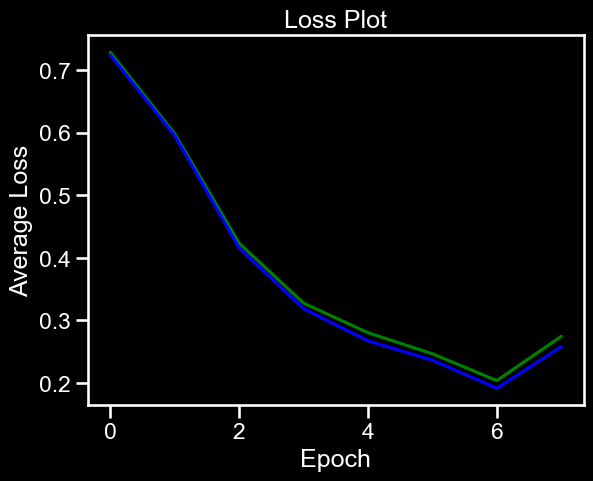

In [85]:
# draw the losses of the best model
best_train_losses = fold_losses
best_valid_losses = valid_losses

plt.plot(best_train_losses, color='green')
plt.plot(best_valid_losses, color = 'blue')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Loss Plot')
plt.show()


In [86]:
print(len(best_train_losses))

8


# Evaluation

In [87]:
#import gc
#tokenizer = None
#best_model = None
#model = None
#torch.cuda.empty_cache()
#gc.collect()

In [88]:
def get_roc_auc(test_label, y_prob):
    # input: test_labels dim: (num_samples, num_labels), y_prob dim: (num_samples, num_labels)
    y_label_np = test_label.numpy() if hasattr(test_label, 'numpy') else test_label.cpu().numpy()
    y_test_np = y_prob.numpy() if hasattr(y_prob, 'numpy') else y_prob.cpu().numpy()

    n_classes = y_label_np.shape[1]  # Number of classes/labels

# Initialize lists to store fpr and tpr for each label
    all_fpr = []
    all_tpr = []
    label_names = []
    auc_scores = []
    # Compute ROC curve for each label
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_label_np[:, i], y_test_np[:, i])
        all_fpr.append(fpr)
        all_tpr.append(tpr)
        auc = roc_auc_score(y_label_np[:, i], y_test_np[:, i])
        label_names.append(f"Label {i}")
        auc_scores.append(auc)

    # Plot ROC curve for each label
    plt.figure(figsize=(10, 6))
    for i in range(n_classes):
        plt.plot(all_fpr[i], all_tpr[i], label=f'ROC curve (Label {i})')

    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for each label')
    plt.legend(loc='lower right')
    plt.show()
    auc_table = pd.DataFrame({'Label': label_names, 'AUC Score': auc_scores})

    print(auc_table)
     

In [89]:
def get_accuracy(y_label, y_test):
    prediction = torch.where(y_test > 0.5, 1, 0)
    y_label_np = prediction.numpy() if hasattr(prediction, 'numpy') else prediction.cpu().numpy()
    y_test_np = y_label.numpy() if hasattr(y_label, 'numpy') else y_label.cpu().numpy()
    
    n_class = y_label_np.shape[1]
    n_samples = y_label_np.shape[0]

    total_num = y_label_np.shape[0] * y_label_np.shape[1]
    correct = 0
    for i in range(n_class):
        for j in range(n_samples):
            if y_test_np[j,i] == y_label_np[j,i]:
                correct += 1 
    accuracy = correct / total_num
    return accuracy


In [100]:
#loading test_dataset
test_dataset = BertDataSet(test['clean'], None, tokenizer, 77, if_train = False)
test_dataloader = dataloader.DataLoader(test_dataset, batch_size = 64, pin_memory = True, num_workers = 0, shuffle = True)

config_path = './fintune_bert/config.json'
model_path = './fintune_bert/model.safetensors'

config = transformers.BertConfig.from_json_file(config_path)

best_model = transformers.BertForSequenceClassification.from_pretrained(model_path, config=config).to(device)

best_model = transformers.BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels = 6).to(device)

probability_tensors = None

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [91]:
print(len(test_dataset))

1000


In [101]:
best_model.eval()
with torch.no_grad():
    for test in tqdm(test_dataloader):
        
        ids = test['input_ids'].to(device)
        mask = test['mask'].to(device)
        outputs = best_model(ids, mask)
        #print(outputs.keys())
        results = outputs['logits']
        #print(results)
        
        raw_predictions = torch.sigmoid(results)    
        prediction = torch.where(raw_predictions > 0.5, -1, 0)
        
        #print(raw_predictions)
        #print(prediction)
        
        if probability_tensors == None:
            probability_tensors = raw_predictions
        else:
            probability_tensors = torch.cat((probability_tensors, raw_predictions), dim=0)
            
        #break
        
    probability_tensors = probability_tensors.detach().to('cpu')   
    print(probability_tensors)

100%|██████████| 16/16 [00:01<00:00, 10.15it/s]

tensor([[0.2904, 0.5286, 0.3729, 0.4817, 0.5380, 0.3027],
        [0.2838, 0.5472, 0.3924, 0.5099, 0.5260, 0.3553],
        [0.2958, 0.5413, 0.3896, 0.4894, 0.5306, 0.3419],
        ...,
        [0.2796, 0.5328, 0.3881, 0.5008, 0.5397, 0.3376],
        [0.2850, 0.5516, 0.3983, 0.5003, 0.5213, 0.3665],
        [0.2790, 0.5648, 0.4120, 0.4830, 0.5368, 0.3655]])


#

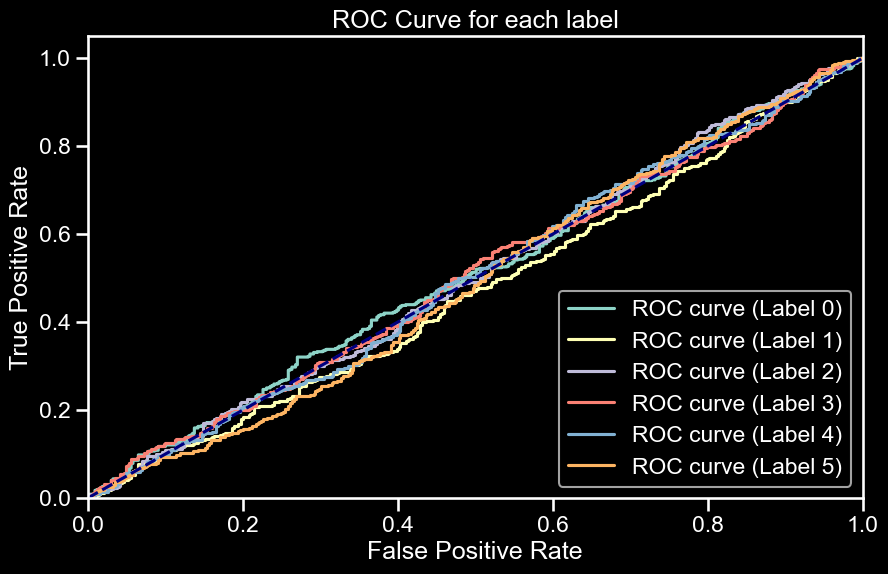

     Label  AUC Score
0  Label 0   0.510251
1  Label 1   0.475639
2  Label 2   0.506036
3  Label 3   0.504566
4  Label 4   0.501619
5  Label 5   0.491462


In [102]:
ground_truth = torch.tensor(test_label[['toxic', 'severe_toxic','obscene', 'threat', 'insult','identity_hate']].values)
y_label = torch.where(ground_truth == -1, 1,0)
y_rand = torch.rand(200,6)
# print(y_test)
# print(y_label)
get_roc_auc(y_label, probability_tensors)
#get_roc_auc(y_label, y_rand)

In [103]:
get_accuracy(y_label, probability_tensors)

0.47783333333333333